# DGP classic_rct_gamma_26


# Math Explanation of the `classic_rct_gamma_26` DGP


The `classic_rct_gamma_26` function generates a synthetic dataset for a **Classic Randomized Controlled Trial (RCT)**. Treatment is assigned completely at random, and covariates $X$ affect the outcome (prognostic) but do not influence treatment assignment (no confounding).

By default, it simulates a **revenue** experiment (gamma outcome) with 10,000 samples and a 50/50 split.



## Covariate Generation (Confounders)


Three binary covariates $X = [x_1, x_2, x_3]$ are generated independently:
*   **`platform_ios`** ($x_1$): $x_1 \sim \text{Bernoulli}(0.5)$
*   **`country_usa`** ($x_2$): $x_2 \sim \text{Bernoulli}(0.6)$
*   **`source_paid`** ($x_3$): $x_3 \sim \text{Bernoulli}(0.3)$



## Treatment Assignment ($D$)


Since it is an RCT, the treatment $D$ is independent of $X$. It is assigned with a probability $P(D=1) = 0.5$:
$$D \sim \text{Bernoulli}(0.5)$$
The log-odds of treatment (intercept $\alpha_d$) is $0$.


## Outcome Generation (`revenue`)

The outcome is a positive, skewed metric (e.g., revenue) modeled with a **Gamma** distribution using a log-mean link:
$$Y \mid D, X \sim \text{Gamma}(k, \theta)$$
$$\log \mathbb{E}[Y \mid D, X] = \log(k \cdot \theta_A) + \beta_y^\top X + g_y(X) + D \cdot \log(\theta_B/\theta_A)$$

By default, $g_y(X)=0$ because `add_pre=False`. The nonlinear term is only included when `add_pre=True` (or when `g_y`/`use_prognostic` is provided).

*   **Shape ($k$):** Default $k=2.0$.
*   **Scale (control $\theta_A$):** Default $15.0$.
*   **Scale (treatment $\theta_B$):** Default $16.5$.
*   **Prognostic Coefficients ($\beta_y$):** Default $[0.25, 0.20, 0.45]$. These values shift the log-mean of revenue.


With the defaults, the group means are:
$$\mathbb{E}[Y \mid D=0] = k \cdot \theta_A = 2.0 \times 15.0 = 30.0$$
$$\mathbb{E}[Y \mid D=1] = k \cdot \theta_B = 2.0 \times 16.5 = 33.0$$
This corresponds to a 10% uplift on the mean scale before covariate effects.



## Summary of Default Parameters


*   **$N$**: 10,000
*   **Control Mean (baseline)**: $30.0$ at $X=0$
*   **Treatment Mean (baseline)**: $33.0$ at $X=0$
*   **Treatment Split**: 50%
*   **Confounders**: 3 binary
*   **Nonlinear $g_y(X)$**: only when `add_pre=True` or `g_y`/`use_prognostic` is provided


# DGP


In [1]:
from causalis.data_contracts import CausalData
from causalis.scenarios.classic_rct.dgp import classic_rct_gamma_26

# let's generate a df
data = classic_rct_gamma_26(return_causal_data=False, include_oracle=True)
data.head()


,user_id,revenue,d,platform_ios,country_usa,source_paid,age,cnt_trans,platform_Android,platform_iOS,invited_friend,m,m_obs,tau_link,g0,g1,cate
0,ae006,62.015001,0.0,1.0,0.0,1.0,39,0,0,1,0,0.5,0.5,0.09531,60.412581,66.453839,6.041258
1,6051e,22.353186,1.0,0.0,0.0,1.0,46,4,0,1,0,0.5,0.5,0.09531,47.049366,51.754302,4.704937
2,eb08c,38.213100,0.0,1.0,1.0,0.0,36,1,1,0,0,0.5,0.5,0.09531,47.049366,51.754302,4.704937
3,a947a,77.927095,1.0,1.0,1.0,0.0,26,2,0,1,0,0.5,0.5,0.09531,47.049366,51.754302,4.704937
4,9bd42,24.936085,1.0,0.0,1.0,0.0,35,3,0,1,0,0.5,0.5,0.09531,36.642083,40.306291,3.664208


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")


Ground truth ATE is 4.547002938251698
Ground truth ATTE is 4.571328700457634


In [3]:
# wrap it in CausalData
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='revenue',
                        confounders=['platform_ios', 'country_usa', 'source_paid'])
causaldata


CausalData(df=(10000, 5), treatment='d', outcome='revenue', confounders=['platform_ios', 'country_usa', 'source_paid'])

# EDA

In [4]:
# Statistics for outcome comparison
from causalis.shared import outcome_stats

outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,4955,45.271228,36.185063,0.338380,11.081530,20.326602,35.784254,60.063958,89.576241,431.357219
1,1.0,5045,50.328883,38.802710,0.448255,12.335521,22.792900,41.149396,67.409299,100.121519,401.883422


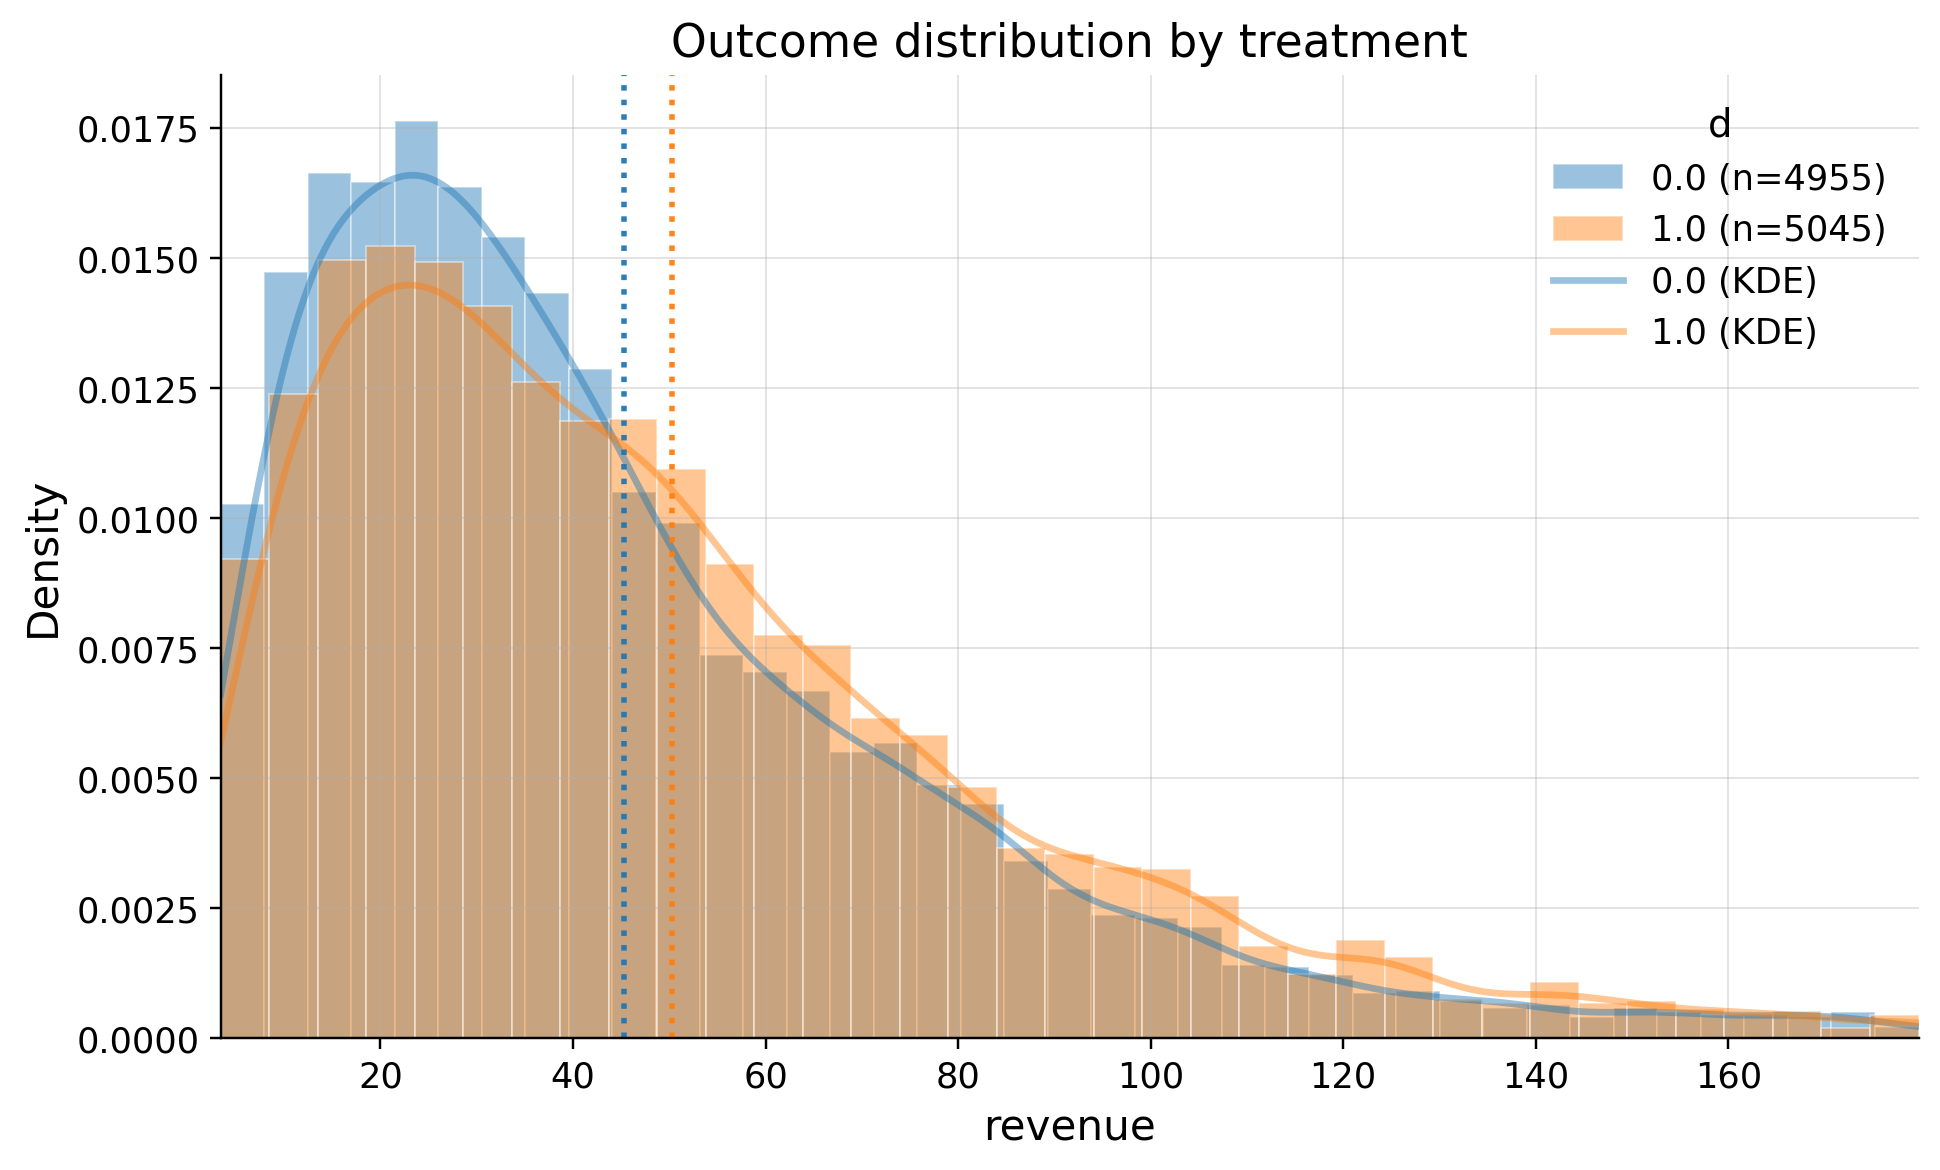

In [5]:
# Statistics for outcome comparison
from causalis.shared import outcome_plot_dist

outcome_plot_dist(causaldata)

## Balance check

In [6]:
# Let's check the balance of confounders
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,source_paid,0.299092,0.313776,0.014684,0.031853,0.64592
1,platform_ios,0.494046,0.502874,0.008828,0.017654,0.98861
2,country_usa,0.586276,0.591873,0.005597,0.011374,1.00000
